# Analyis and Model Development
Using clean scraped data and:
1. Performed univariate, multivariate analysis for both quantitative and categorical data
2. Looked at Data Interaction of correlated data. Visualised Listings using Gmaps API.
3. Feature Selection using Recursive Feature Elimination after feature encoding, not used in production model.
4. Modelling using RandomForest Regressor, XGBoost Regressor, validated using visualisations and 5 fold Cross Validation.
5. RandomSearchCV for Hyperparameter optimisation.
6. Created Pipeline to be used for Flask App and serialised model using joblib.

In [2]:
# Get the Scraped data and Engineer features, data type transformation etc. 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
import os
from geopy.distance import geodesic
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.pipeline import Pipeline
import joblib
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, SCORERS, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import RFE
from xgboost import XGBRegressor
sns.set_palette('husl')

### Strategy to Deal with outliers
Removed extreme outliers when it comes to rental price and size. 

In [3]:
rent_data= pd.read_csv('Data/Rent_data_makaan_june_13_metro_closest_stations.csv', index_col=0)

In [4]:
# Removing Extreme outliers (Central Delhi listings in multiple tens of lakhs. Extremely Large houses, listings 
# in the extreme outskirts of Delhi)
rent_data = rent_data[rent_data.price < 510000]
rent_data = rent_data[rent_data.size_sq_ft < 16000]
rent_data = rent_data[rent_data.closest_mtero_station_km < 11]
rent_data.reset_index(drop=True, inplace=True)

All Data Wrangling/Feature Engineering in seperate notebook called 'Wrangling'.<br>
12099 Listings in Dataset.

# Analysis of data

## Univariate Analysis -  Quantitative Variables
Looking at distributions of the quantitaive columns, investigating interesting columns later.

1. Size in Square Feet - The distribution of size of houses has a mean around 1100 sq.feet and is heavily positively skewed, long tail of larger houses.
2. Bedrooms is a discrete variable and we can see that the most common arrangement is a 2 bedroom house.
3. The latitude and longitude appear to be multimodal as the dataset contains listings from 5 different regions of the city, and the dataset doesn't appear to have an imbalance of houses from a single region of the city(more on that later). The co-ordinates have been used to calculate distances from important landmarks and the metro stations.
4. Price(Monthly Rent) is the target variable and has a similar distribution to size with most listings around the 20,000 range. Again highly skewed, Log transformed later.
5. Closest Metro Station - most listings are closer to metro stations, similar distribution to price and size. The outliers are places like bawana etc in the North. This is geodisc distance, so not as useful as road distance which can be found using the GMaps API but is a paid feature. https://developers.google.com/maps/documentation/distance-matrix/usage-and-billing
6. Airport, AIIMS, NDLS Railway Station distance from listings is also visualised, could be important considerations for listings but can also lead to collinearity (checked later).

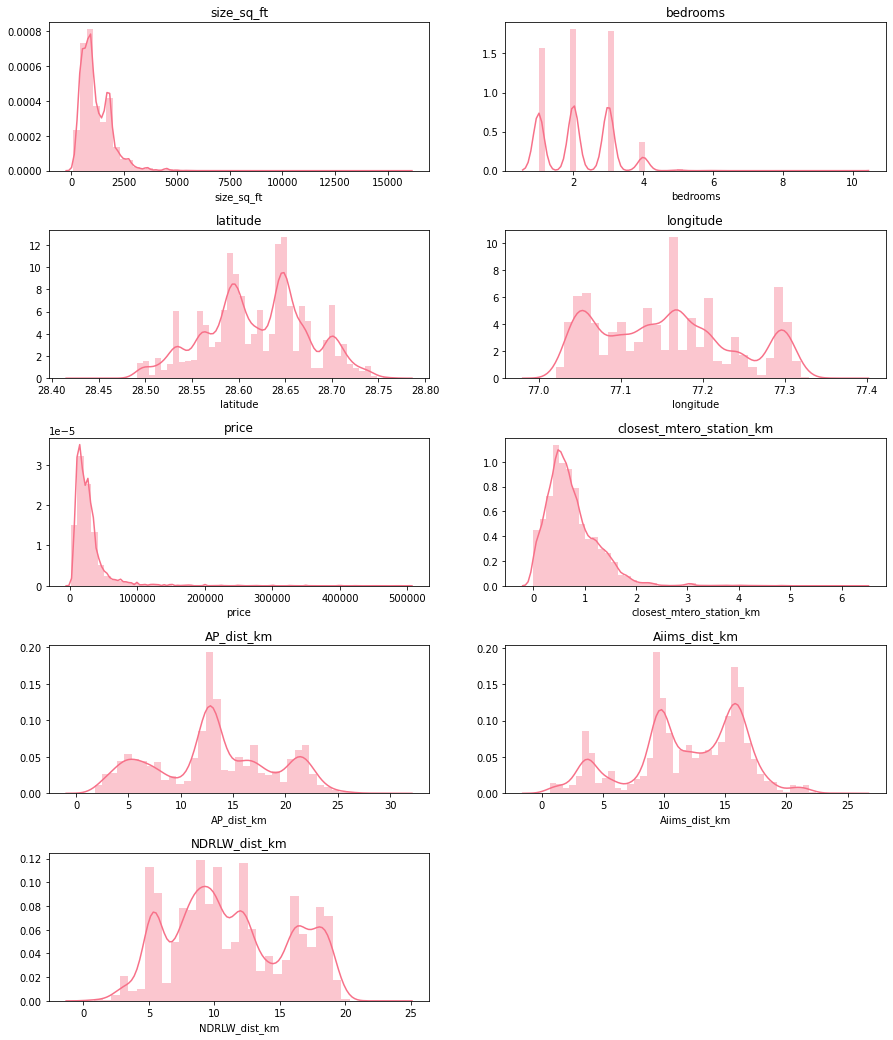

In [4]:
fig = plt.figure(figsize=(15,18))
for i,item in enumerate(rent_data.select_dtypes([np.number]).columns):
    ax = fig.add_subplot(5, 2, i+1)
    fig.subplots_adjust(hspace=0.4)
    sns.distplot(rent_data[item])
    ax.set_title(item)

### Boxplot to check for outliers
Again, size, price and closest metro stations are heavily skewed columns.Can benefit from a log transformation.

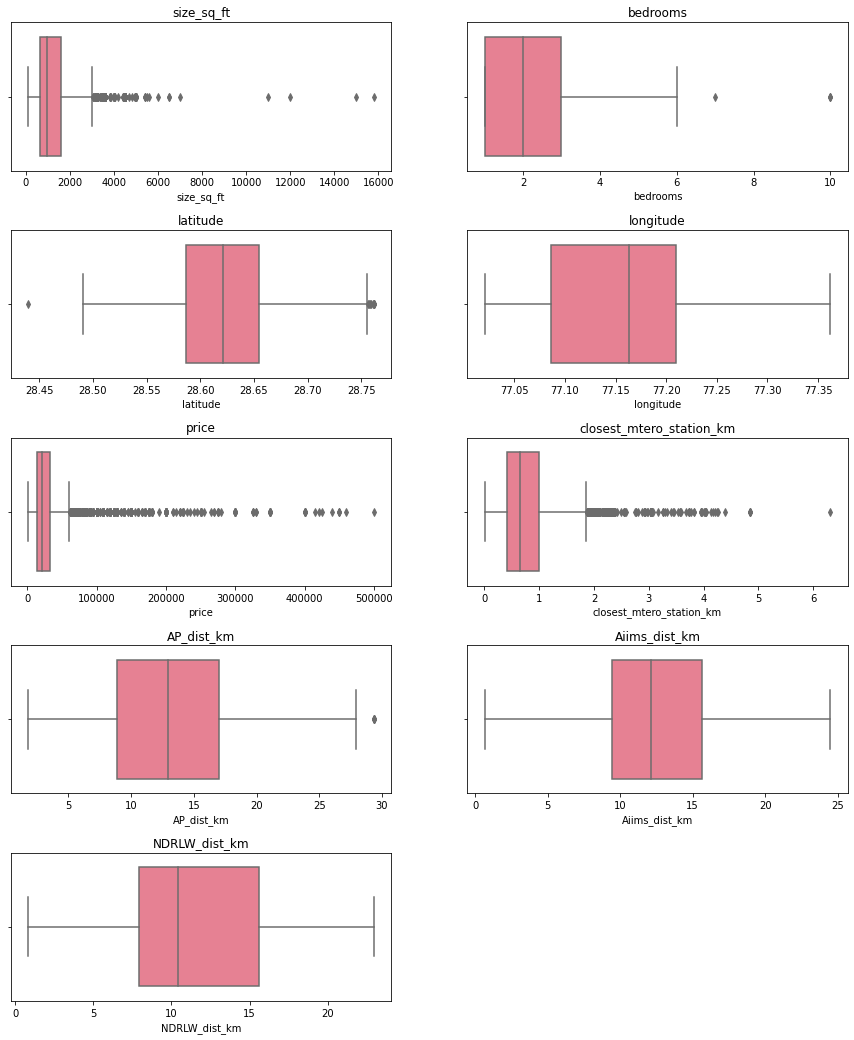

In [5]:
fig = plt.figure(figsize=(15,18))
for i,item in enumerate(rent_data.select_dtypes([np.number]).columns):
    ax = fig.add_subplot(5, 2, i+1)
    fig.subplots_adjust(hspace=0.4)
    sns.boxplot(rent_data[item])
    ax.set_title(item)

#### Closer look at target - Price (monthly rent)
Very Heavily skewed with a median at Rs.20K and 75% of the listings below Rs.40K.(Outliers in target is a big problem). 
<br>Although the tree based regression methods used later are robust to outliers and don't require the target to be normal, log transforming the target gives it a normal-ish distribution and results in .2-.3 increase in R<sup>2</sup> Score.

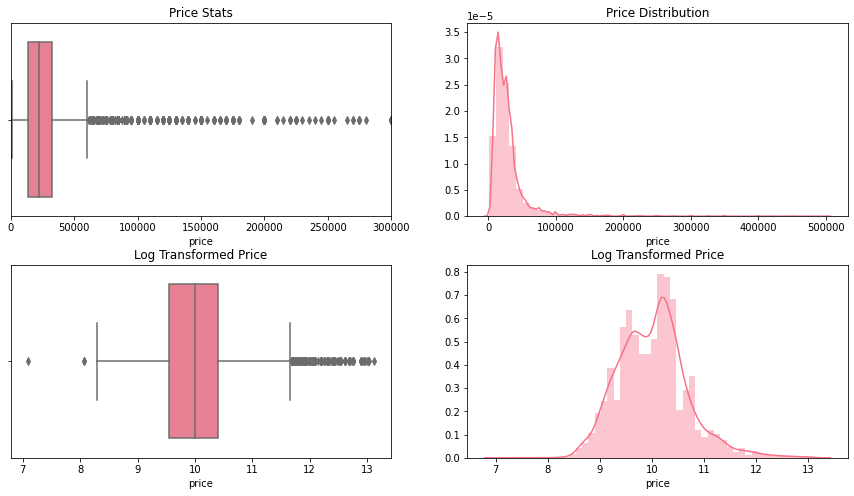

In [6]:
fig, axes = plt.subplots(2,2, figsize = (15,8))
fig.subplots_adjust(hspace=0.25)
axes[0][0].set_xlim(0, 300000)
axes[0][0].set_title('Price Stats')
sns.boxplot(rent_data.price, ax = axes[0][0])
axes[0][1].set_title('Price Distribution')
sns.distplot(rent_data.price, ax = axes[0][1])
axes[1][0].set_title('Log Transformed Price')
sns.boxplot(np.log(rent_data.price), ax = axes[1][0])
axes[1][1].set_title('Log Transformed Price')
sns.distplot(np.log(rent_data.price), ax = axes[1][1])
plt.show()

## Univariate Analysis - Categorical Variables

1. Just a simple self explanatory value counts of the data displaying the most dominant class in the categorical data. 
2. Most listings are for Independednt floors, and the division of listings is pretty equal between the different regions of the city if we include Rohini in the northern part of the city. Care was taken to make sure equal proportion in both train and validation set when modeling.
3. 2BHK is the most common arrangement but this differs by region as analysed later. 
4. The most prevalent dealers are a good predictor but have been left out keeping production considerations in mind, users are not expected to have dealer preferences/constraints in mind. Also had high cardinality (~500 values, encoded down to 133 by grouping all dealers with less than 10 listings as independent.) 
5. The cityName column was dropped and PropertyType, suburbname were one hot encoded as is. 
6. Locality name had high cardinality (160) but proved to be a good predictor and was one-hot encoded as is without modification.
7. The bedrooms predictor had high collinearity with size in sq.feet and was dropped with minimal penalty in accuracy and improved cross-validation R<sup>2</sup> std. dev.

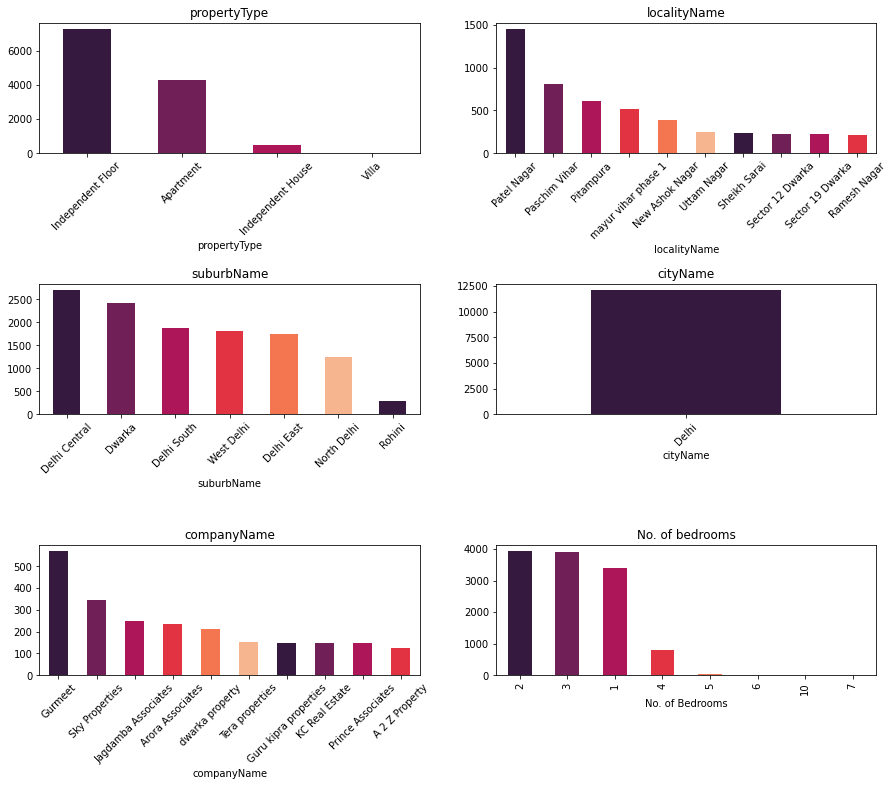

In [7]:
fig = plt.figure(figsize=(15,12))
for i,item in enumerate(rent_data.select_dtypes('object').columns):
    ax = fig.add_subplot(3, 2, i+1)
    fig.subplots_adjust(hspace=1)
    rent_data[item].value_counts()[:10].plot(kind = 'bar', rot = 45,
                                             color = sns.color_palette('rocket')).set(xlabel=item)
    ax.set_title(item)

ax = fig.add_subplot(3, 2, 6)
ax.set_title('No. of bedrooms')
rent_data.bedrooms.value_counts().plot(kind = 'bar',color = sns.color_palette('rocket')).set(xlabel='No. of Bedrooms')
plt.show()

## Multivariate Analysis and Data Interaction
1. Looking at the geographical distribution of listings, they are reasonably distributed between the regions of Delhi.
2. Looking at the distributions of price and size, there seems to be high correlation between them(confirmed later using a coreelation matrix) and is an important predictor.
3. ALso evident is the distinction of areas where smaller and more affordable houses (East Delhi) are located and areas with a large right tail (South Delhi) which are posh areas. 
4. Most Listings are close to metro stations. Could be an interesting predictor.

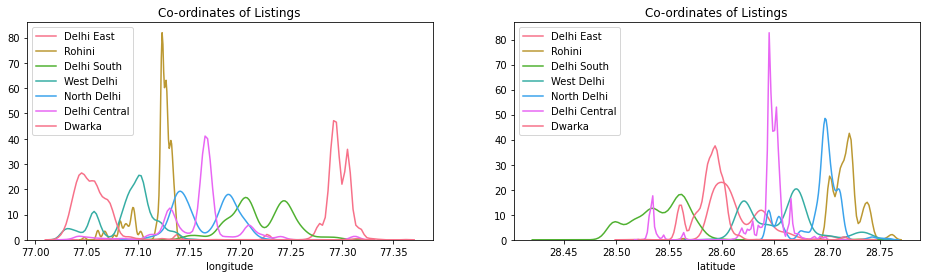

In [8]:
fig, axes = plt.subplots(1,2, figsize = (16,4))
for item in rent_data.suburbName.unique():
    sns.distplot(rent_data.longitude.loc[rent_data.suburbName == item],label = item, ax = axes[0]
                 , hist = False).set(title = 'Co-ordinates of Listings')
    axes[0].legend()
for item in rent_data.suburbName.unique():
    sns.distplot(rent_data.latitude.loc[rent_data.suburbName == item],label = item, ax = axes[1]
                 , hist = False).set(title = 'Co-ordinates of Listings')
    axes[1].legend()
plt.show()

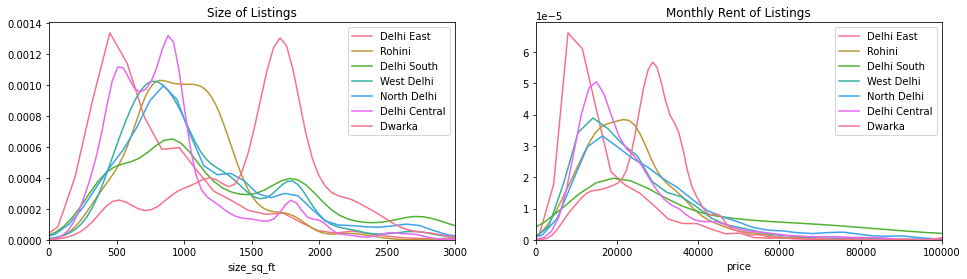

In [9]:
fig, axes = plt.subplots(1,2, figsize = (16,4))
for item in rent_data.suburbName.unique():
    sns.distplot(rent_data.size_sq_ft.loc[rent_data.suburbName == item],label = item
                 , ax = axes[0], hist = False).set(title = 'Size of Listings')
    axes[0].set_xlim(0,3000)
    axes[0].legend()
for item in rent_data.suburbName.unique():
    sns.distplot((rent_data.price.loc[rent_data.suburbName == item]),label = item, ax = axes[1],
                 hist = False).set(title = 'Monthly Rent of Listings')
    axes[1].set_xlim(0,100000)
    axes[1].legend()
plt.show()

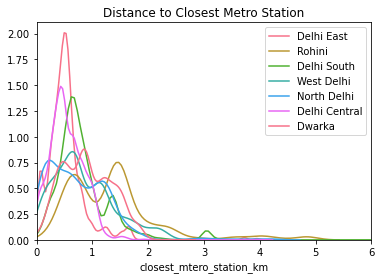

In [10]:
plt.xlim(0,6)
for item in rent_data.suburbName.unique():
    sns.distplot(rent_data.closest_mtero_station_km.loc[rent_data.suburbName == item],
                 label = item, hist = False).set(title = 'Distance to Closest Metro Station')
plt.legend()
plt.show()

#### Price and Size of listings by Regions
1. Unsurprisingly the most expensive and larger listings are from South Delhi.
2. Most regions have a large number of outliers that can prove problematic when modeling.

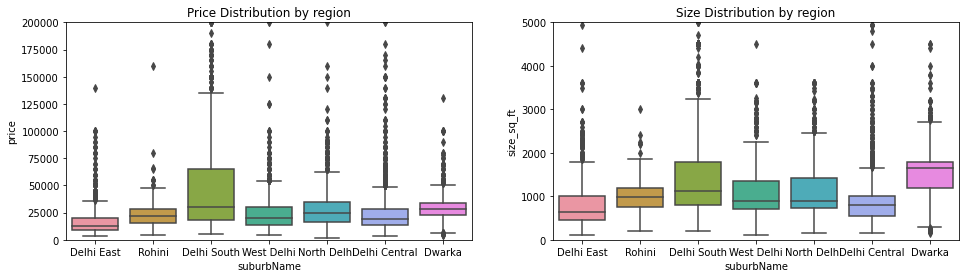

In [11]:
fig, axes = plt.subplots(1,2, figsize = (16,4))
sns.boxplot(x = 'suburbName', y = 'price',
            data = rent_data, ax = axes[0]).set(title = 'Price Distribution by region')
axes[0].set_ylim(0, 200000)
sns.boxplot(x = 'suburbName', y = 'size_sq_ft'
            , data = rent_data, ax = axes[1]).set(title = 'Size Distribution by region')
axes[1].set_ylim(0, 5000)
plt.show()

#### Division of Property Type and no. of bedrooms by Region.
1. Again, the majority of houses in South Delhi are 3+ bedrooms. 
2. In the other regions the typical listing is of smaller hosues. 
3. Most listings are of independent floors, Dwarka has mostly listings of apartments.

In [12]:
# pivot table to get in format suitable for stacked bargraphs
bed_sub = rent_data.pivot_table(columns='bedrooms', index='suburbName',
                      aggfunc='count').iloc[:,:6]
prop_sub = rent_data.pivot_table(columns='propertyType', index='suburbName',
                      aggfunc='count').iloc[:,:4]

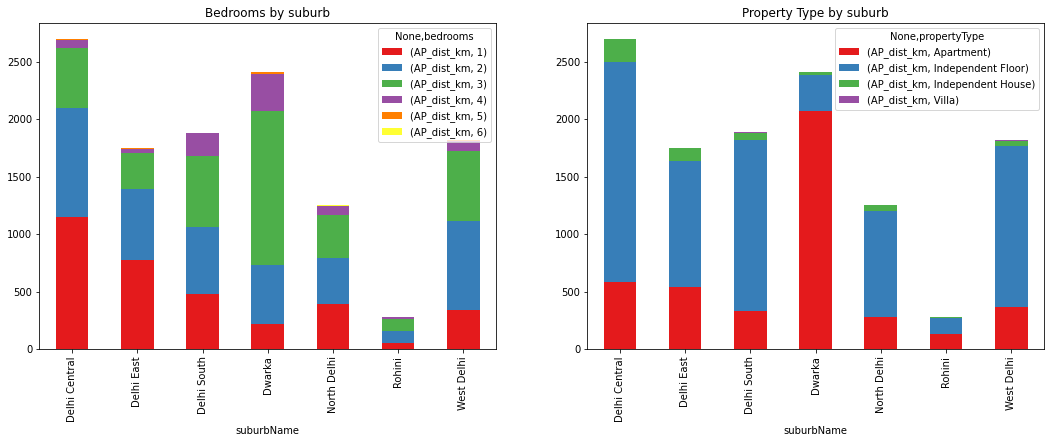

In [13]:
fig, axes = plt.subplots(1,2, figsize = (18,6))
bed_sub.plot(kind = 'bar',stacked = True,color =sns.color_palette('Set1'), ax = axes[0], title = 'Bedrooms by suburb')
prop_sub.plot(kind = 'bar',stacked = True, color =sns.color_palette('Set1'), ax = axes[1], title = 'Property Type by suburb')
plt.show()

## Correlation Analysis - Checking Persons correlation for continuous variables.
<b>Collinearity is when the predictors are correlated</b>
1. In the regression context, collinearity between predictors (> .7 Pearsons R) results in less stable and interpretable results, most ML algorithms can deal with collinear predictors when it comes to predictive modelling, but dropping the collinear columns resulted in less standard deviation in the cross validated R<sup>2</sup> score and lower MAE, MSE.
2. Dropped bedrooms(correlated with size), co-ordinates(correlated with landmarks)

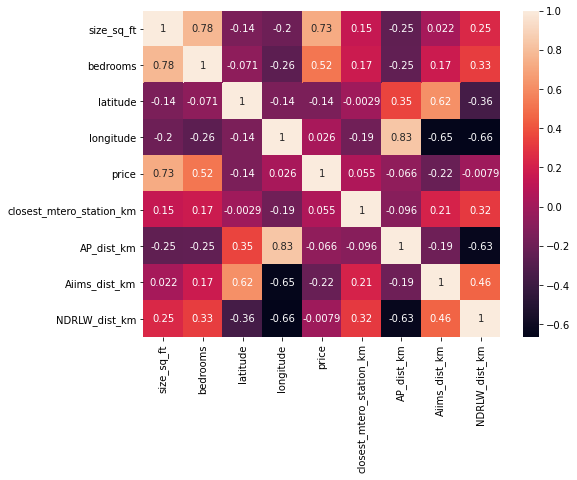

In [14]:
plt.figure(figsize = (8,6))
sns.heatmap(rent_data.corr(method='pearson'), annot=True)
plt.show()

In [15]:
# Most correlated features - After Dropping co-ordinates, Keeping bedrooms for now, just for visualisations.
temp_corr = rent_data.corr()
corr_list = []
pair_feat = []
for i, item in enumerate(list(combinations(temp_corr.drop(['latitude', 'longitude'], axis =1).columns.to_list(),2))):
    pair_feat.append(item)
    
for item in pair_feat:
    corr_list.append([item[0], item[1], np.abs(temp_corr.at[item[0], item[1]])])

corr_array = np.array(corr_list)
corr_array = corr_array[corr_array[:,2].argsort()][::-1]

### Data Interaction of correlated features
1. Strong positive Linear relationship between size of house and monthly rent. The relationship appear to be non linear for listings in south Delhi (Blue), clearly other variables at play. 
2. Expected positive relation between bedrooms and size. 
3. Bedrooms and price has a similar positive linear relationship as with size. 
4. The price and distance from Airport, AIIMs plot (7, 10) show that their isn't a strong negative relationship between the two, might not be that effective for predictions.
5. The rest of the correlated predictors are just the distance between landmarks and don't have predictive value.

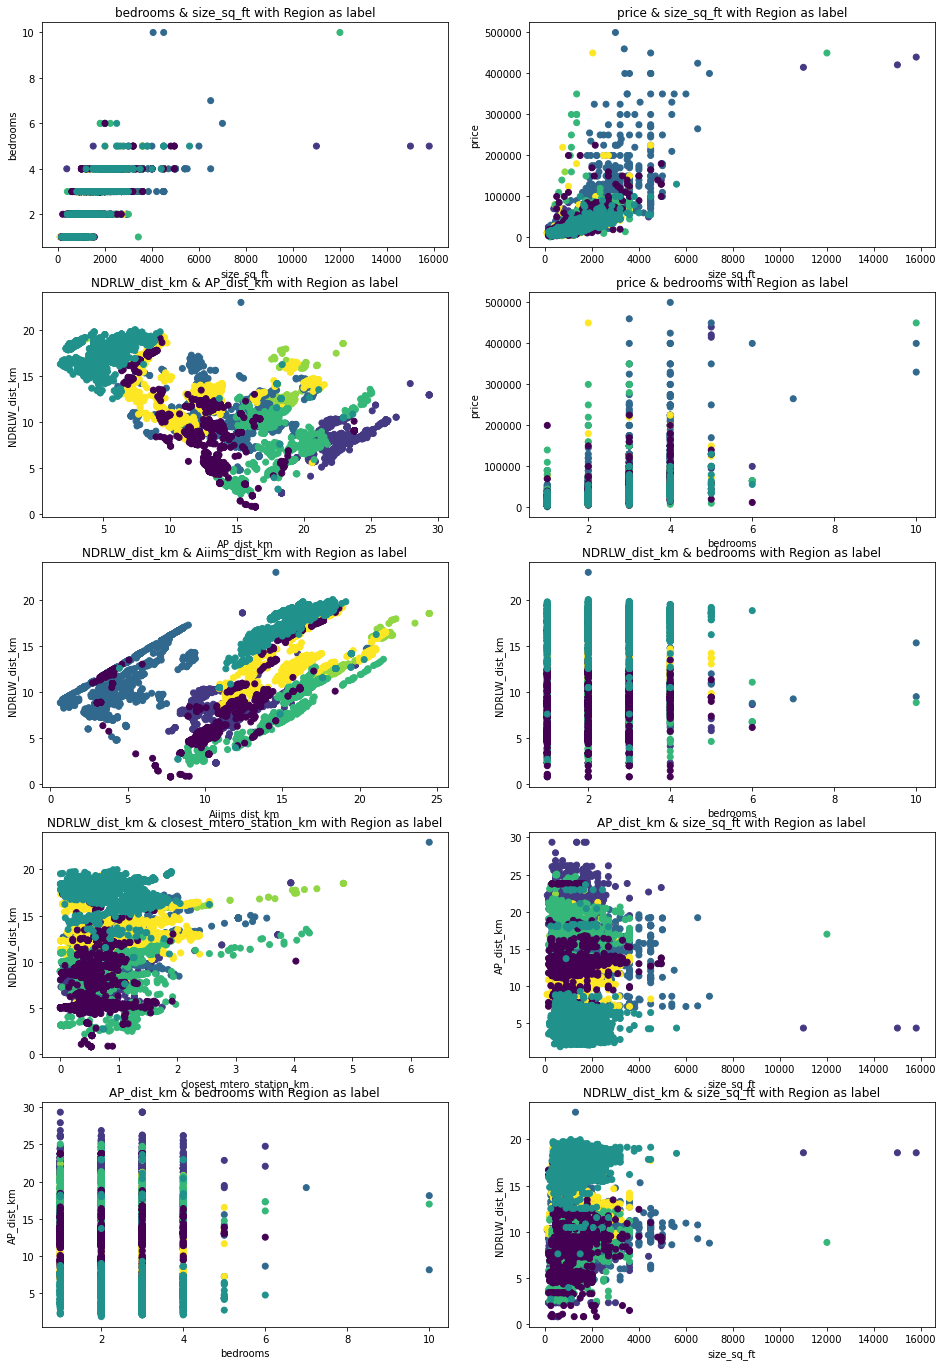

In [16]:
fig = plt.figure(figsize = (16,24))
for i, item in enumerate(corr_array[:10]):
    ax = fig.add_subplot(5, 2, i+1)
    plt.scatter(x = rent_data[item[0]].values, y = rent_data[item[1]].values,
                c = LabelEncoder().fit_transform(rent_data.suburbName.values))
    ax.set_title(item[1] + ' & ' + item[0] + ' with Region as label') 
    ax.set_xlabel(item[0])
    ax.set_ylabel(item[1])    
plt.show()

#### Difference between size and price relationship acrosss regions
Shows that listings in south Delhi command a premium over ones in North Delhi, followed closely by the other regions.

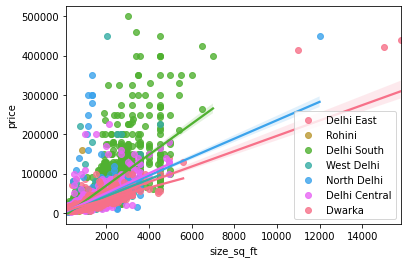

In [17]:
for item in rent_data.suburbName.unique():
    sns.regplot( x= 'size_sq_ft', y = 'price', data = rent_data.loc[rent_data['suburbName'] == item],
                label = item, robust = True)
    plt.legend()

### Visualising Rent Market Trends
Embedded figure, created using Gmaps API and coordinates of listings. heat map layer that will tell us where the highest rents of the city are. <br>
1. Most high value properties are clustered in South Delhi, Patel Nagar, Paschim Vihar, Dwarka. The variety in listings (Apartments, floors, houses) and extreme outliers makes it difficult to compare at this scale but general trends are visible.<br>
The max intensity is rent of Rs.2 lakh/mo.
![](Static/complete_heatmap_2lac.png)

### Data Transformations 

In [910]:
# Optional, if using company name as feature.
rent_data.companyName.value_counts().loc[rent_data.companyName.value_counts() > 10]
redundant = rent_data.companyName.value_counts().loc[rent_data.companyName.value_counts() < 10].index.to_list()
for item in redundant:
    rent_data.loc[(rent_data.companyName == item),['companyName']] = 'Independent'

In [174]:
# Optional, doesn't help that much.
log_price = np.log(rent_data.price)
rent_data['price'] = log_price

# Modelling - Using Tree based Regresion Methods
Tree based Regression methods offer great performance, are robust to outliers, scale invariant and Boosted trees often beat more sophisticated methods. <br><br>
Disadvantages include the fact that tree based methods can't predict outside the domain of the training features, but for a general purpose rent prediction it is safe to assume most users will be expecting to rent properties within the constraints of the average listings on a rental website. Representative data splitting is also important, predicitions by tress can vary a lot depending upon the distributions of the train and validation splits. <br>
Hyperparameter optimisation doesn't improve scores by much.<br>
<b> Evaluation Metric </b> : MSE is less robust to ouliers in target compared to MAE. R<sup>2</sup> is a proportion but can be misleading, for example just changing the scale of the target to log improved the score, but the model is the same. Goal is reducing MAE. <br>
Models used:
1. Random Forest Regressor for feature selection and tuning.
2. XGBoost regressor for final Model

#### Performance/Tuning Log
1. Performance of models  tested with random_state = 50 for fair comparison, slight variation due to tree formation.
2. RFE performed later.

| Model | 10 folds CV Train R<sup>2</sup>, std dev| CV Train MAE |CV Train MSE |Validation R<sup>2</sup>| Validation MAE| Validation MSE
|------|------|------|------|------|------|------|
|   <b> Random Forest Baseline </b>- Only using Area and bedrooms  | 0.547, stdev 0.049|9022 |449074286|0.580|8617|406796733
|Scaled Columns(No sig. Difference, still scaling)|0.546, stdev 0.050|9044|450677905|0.573|8646|413575851|
|Log transformed target (can't directly compare except test inverse R<sup>2</sup>, Final model will have log target)| 0.713, stdev 0.019|0.260356486|0.1269002796|0.629(inverse),0.742| 0.253155159|0.1135503878
| Dropped bedrooms (Collinear)|0.534, stdev 0.044|9097|463727902|0.586|8737|401611906
|One-hot encoded property type(4)|0.581, stdev 0.019|8491|415211922|0.591|8257|396521618|
|Encoded SuburbName|0.663, stdev 0.031|7440|334921366|0.650|7133|339424986
|Dropped suburbname, and encoded localityName(could be collinear)|0.718, stdev 0.043|6603|281198297|0.692|6271|298000804
|Encoded locality Name|0.746, stdev 0.036|6417|252516309|0.711|6199|279827597
|One-hot encoded company name, but not practical constraint for users| 0.780, stdev 0.027|5984|218246210|0.753|5757|239526157
|Removed company name, Added Only Distance from Airport_km(Doesn't Help)| 0.736, stdev 0.033|6495|263137293|0.719|6246|272653107
|Added Only Distance from AIIMS_km(Doesn't Help)| 0.746, stdev 0.041|6375|252273469|0.719|6284|272579420
|Added Only Distance to NDLS station(Helps)|0.750, stdev 0.030|6419|248325056|0.747|6118|245460539
|Added Only Distance to Closest Metro Station(Doesn't help)|0.735, stdev 0.022|6504|263770861|0.715|6209|275748353
|Log transform target|0.821, stdev 0.010|0.1952848861|0.0791067981|0.749(inverse),0.839|0.1872852488| 0.0707627291
|RandomSearchCV Optimised Parameters|0.731, stdev 0.040|6309|263240934|0.722|6133|269614093
|RFE to select the 10 best ranked features, much reduced training time|0.732, stdev 0.047|6672|262005527|0.742|6343|249731133

In [6]:
# Preparing Features
def feat_prep(df):
    temp = df.copy()
    temp.drop(['bedrooms'], axis = 1, inplace = True)
    temp = pd.concat([temp,pd.get_dummies(temp.suburbName, prefix='sN_')], axis = 1)
    temp.drop(['suburbName'], axis = 1, inplace=True)
    temp = pd.concat([temp,pd.get_dummies(temp.propertyType, prefix='pT_')], axis = 1)
    temp.drop(['propertyType'], axis = 1, inplace=True)
    temp = pd.concat([temp,pd.get_dummies(temp.localityName, prefix='lN_')], axis = 1)
    temp.drop(['localityName'], axis = 1, inplace=True)
    # for attemp 8 only companyName
    #temp = pd.concat([temp,pd.get_dummies(temp.companyName, prefix='cN_')], axis = 1)
    #temp.drop(['companyName'], axis = 1, inplace=True)
    labels = temp.price
    print(f'Total Feature {len(temp.columns)}')
    temp.drop(['price'], axis = 1, inplace=True)
    
    return temp, labels

In [7]:
data, labels = feat_prep(rent_data)

Total Feature 301


In [8]:
# Columns to drop after feature selection
drop_cols = ['latitude', 'longitude', 'cityName', 'companyName',
             'AP_dist_km', 'Aiims_dist_km','closest_mtero_station_km'
              ]

In [9]:
# random state to get identical copy below.
final_feats = data.drop(drop_cols, axis = 1)
x_train_og, x_test_og, y_train, y_test = train_test_split(final_feats, labels, test_size = .30,
                                                   shuffle = True, random_state = 50)

In [10]:
scale = StandardScaler()
scale.fit(x_train_og)
x_train = scale.transform(x_train_og)
x_test = scale.transform(x_test_og)

#### Train- test Balance for suburbName

In [11]:
# Wouldn't work with attempts where suburbname dropped due to being collinear.
for item in rent_data.suburbName.unique():
    train = x_train_og['sN__'+ item].value_counts()[1]/x_train_og['sN__' + item].value_counts()[0]
    test = x_test_og['sN__' + item].value_counts()[1]/x_test_og['sN__' + item].value_counts()[0]
    print(f' Train ratio for {item}, {train}')
    print(f' Test ratio for {item}, {test}\n')

 Train ratio for Delhi East, 0.1718555417185554
 Test ratio for Delhi East, 0.16346153846153846

 Train ratio for Rohini, 0.02233220666344761
 Test ratio for Rohini, 0.026874115983026876

 Train ratio for Delhi South, 0.18630060232525564
 Test ratio for Delhi South, 0.180871828236825

 Train ratio for West Delhi, 0.17804979830296286
 Test ratio for West Delhi, 0.17323852617970265

 Train ratio for North Delhi, 0.11639862905351964
 Test ratio for North Delhi, 0.11383860079779073

 Train ratio for Delhi Central, 0.2880608365019011
 Test ratio for Delhi Central, 0.2858660998937301

 Train ratio for Dwarka, 0.24288230114470208
 Test ratio for Dwarka, 0.26260869565217393



## Random Forest
Predictions tend to do be okay in lower price range, Outliers are a big problem. 

In [35]:
# Final Optimised Hyperparamaters 
rf = RandomForestRegressor(n_estimators=222, min_samples_split = 5, min_samples_leaf = 1, max_features='sqrt',
                          criterion = 'mse', max_depth = 40, oob_score = True, n_jobs = -1)

In [19]:
def get_train_metrics(model, x_train, y_train):
    scoring = ['r2', 'neg_mean_absolute_error', 'neg_mean_squared_error']
    score = cross_validate(model, x_train, y_train, cv = 5, scoring=scoring, n_jobs=-1, return_train_score=False)
    r2 = score['test_r2']
    mae = score['test_neg_mean_absolute_error']
    mse = score['test_neg_mean_squared_error']
    print(f'Training Metrics:')
    print(f'R2 : {np.mean(r2)}, stdev {np.std(r2)}')
    print(f'MAE : {np.mean(mae)}, stdev {np.std(mae)}')
    print(f'MSE : {np.mean(mse)}, stdev {np.std(mse)}')

In [26]:
get_train_metrics(rf, x_train, y_train)

Training Metrics:
R2 : 0.7356044178270014, stdev 0.03823805862601674
MAE : -6283.288346344783, stdev 184.15206331114751
MSE : -259778891.685918, stdev 53039620.35716515


In [27]:
def get_test_metrics(model, x_train, x_test, y_train, y_test):
    model.fit(x_train, y_train)
    preds = model.predict(x_test)
    test_r2 = r2_score(y_test, preds)
    test_mae = mean_absolute_error(y_test, preds)
    test_mse = mean_squared_error(y_test, preds)
    print('Testing Metrics:')
    print(f'R2 : {test_r2}')
    print(f'MAE : {test_mae}')
    print(f'MSE : {test_mse}')

In [28]:
get_test_metrics(rf, x_train,  x_test, y_train, y_test)

Testing Metrics:
R2 : 0.7176465937950917
MAE : 6169.335114089734
MSE : 274029024.8661712


#### Visualizing Predictions
1. Looking at the distribution, scatter, residual plot when can see the problems with the model.
2. It is doing a reasonable job of predictings rent for values upto 50K/mo but as we move into higher priced listings the model fails, this is clearly visible in the residual plot below. A solution is to remove the outliers in prices but that limits the usability of the model. Ultimately depends on the objective, if it is reasonable for the use case, this can be fine.
3. Both models slightly overestimate the rent in the lower range.

In [38]:
rf.fit(x_train, y_train)
test_pred = rf.predict(x_test)
print(r2_score(y_test, test_pred))

0.7481731411360375


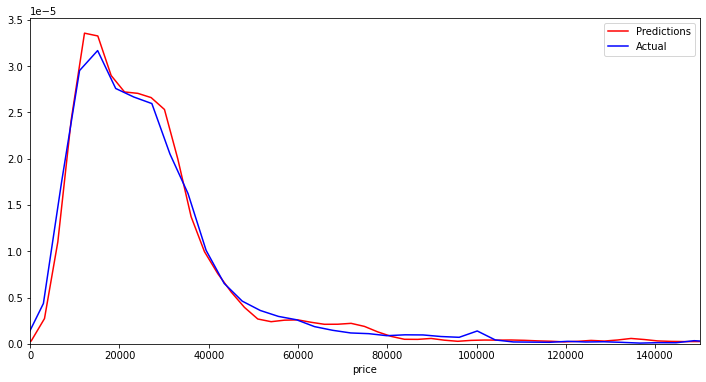

In [39]:
plt.figure(figsize=(12,6))
plt.xlim(0, 150000)
sns.distplot((test_pred), label = 'Predictions', hist = False, color = 'r')
sns.distplot((y_test), label='Actual', hist = False, color = 'b')
plt.legend()
plt.show()

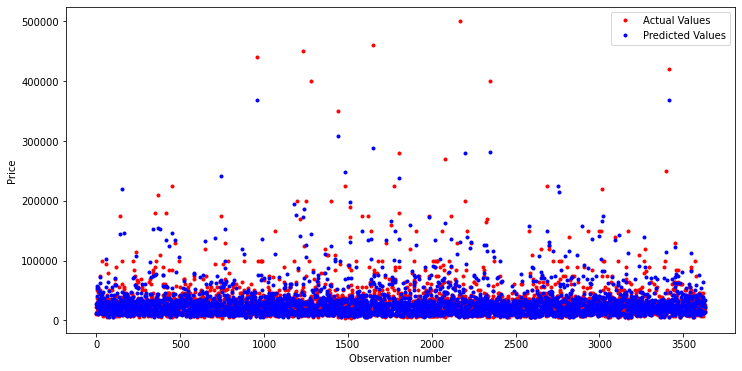

In [40]:
plt.figure(figsize=(12,6))
plt.plot((y_test.to_list()), 'r.', label = 'Actual Values')
plt.plot((test_pred), 'b.', label = 'Predicted Values')
plt.xlabel('Observation number')
plt.ylabel('Price')
plt.legend()
plt.show()

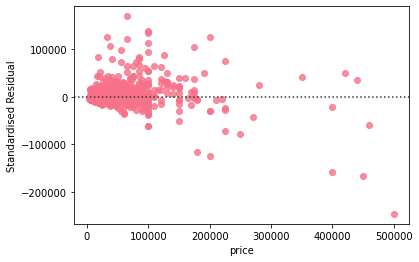

In [41]:
sns.residplot(y_test, test_pred)
plt.ylabel('Standardised Residual')
plt.show()

#### Feature Importance

In [42]:
cols = x_train_og.columns
imp = rf.feature_importances_
feat_imp = pd.DataFrame(data = imp, index=cols)

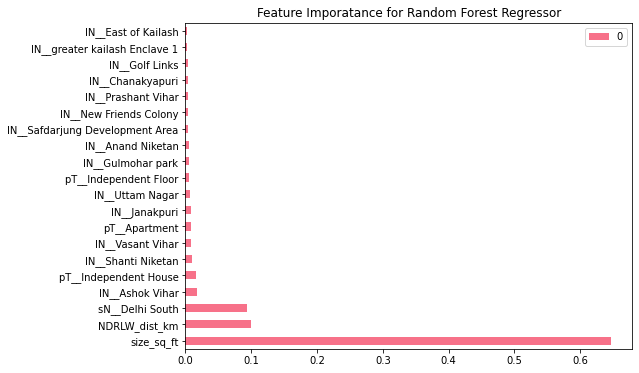

In [43]:
feat_imp.sort_values(by = 0, ascending=False).head(20).plot(kind = 'barh',
                                                            figsize = (8,6)).set(title= 'Feature Imporatance for Random Forest Regressor')
plt.show()

### Feature Selection using Recursive Feature Elimination
RFE is a greedy Technique that uses a model's .coef_ or .feature_importance_ attributes to assign a rank to the features and recursively prune the featureset till it reaches a set number.<br>
This has been kept in to show that the performance is similar or even better with just a few features.
Not used for final model as it makes as it removes a lot of the categorical encoded features. Can use for just the continuous features but have already done that selection manually.

In [44]:
# Fitting RFE
feat_sel = RFE(rf, n_features_to_select=10, step = 10, verbose=0)
feat_sel.fit(x_train, y_train)

RFE(estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                    criterion='mse', max_depth=40,
                                    max_features='auto', max_leaf_nodes=None,
                                    max_samples=None, min_impurity_decrease=0.0,
                                    min_impurity_split=None, min_samples_leaf=1,
                                    min_samples_split=5,
                                    min_weight_fraction_leaf=0.0,
                                    n_estimators=222, n_jobs=-1, oob_score=True,
                                    random_state=None, verbose=0,
                                    warm_start=False),
    n_features_to_select=10, step=10, verbose=0)

In [45]:
# Selected features
pd.DataFrame(data = feat_sel.ranking_, index = x_train_og.columns).sort_values(by = 0, ascending = True).head(20)

,0
size_sq_ft,1
lN__Ashok Vihar,1
lN__Uttam Nagar,1
lN__Vasant Vihar,1
pT__Independent House,1
lN__Shanti Niketan,1
pT__Apartment,1
lN__Janakpuri,1
sN__Delhi South,1
NDRLW_dist_km,1


In [46]:
# Checking Performance
x_train_red = feat_sel.transform(x_train)
x_test_red = feat_sel.transform(x_test)
get_train_metrics(rf, x_train_red, y_train)
get_test_metrics(rf, x_train_red, x_test_red, y_train, y_test)

Training Metrics:
R2 : 0.7166153757641155, stdev 0.04758513363222267
MAE : -6812.107908679041, stdev 272.9461726627973
MSE : -279803708.4290229, stdev 66927616.89004433
Testing Metrics:
R2 : 0.7355234133259634
MAE : 6488.241562852021
MSE : 256679252.14836589


### Hyperparameter Optimisation - Using RandomisedSearchCV
1. Optimising the hyperparamters - number of estimators, no. of features considered at every split, the depth of the trees, the minimum number of samples required required to split a node, min. number of samples required at a node etc.
2. RandomisedGridSearchCV for efficiency, still takes a long time ~30 mins.

In [85]:
# Number of estimtors, lets try between 80 and 400 , 10 equal divisions using linspace
# using list comprehension to conv. to ints.

n_estimators = [int(x) for x in np.linspace(80, 400, 10)]

# Number of features to consider at every split

max_features= ['auto', 'sqrt']

# max num of levels in tree - pruning.

max_depth = [int(x) for x in np.linspace(10, 100, 10)]

# Minimum number of samples required to split a node

min_samples_split = [2, 5, 10]


# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training tree/ whether we want booststrap or not 

bootstrap = [True, False]

random_grid = {'n_estimators' : n_estimators, 
              'max_features': max_features,
              'max_depth': max_depth, 
              'min_samples_split' : min_samples_split,
              'min_samples_leaf': min_samples_leaf,
              'bootstrap' : bootstrap}

In [62]:
random_grid

{'n_estimators': [80, 115, 151, 186, 222, 257, 293, 328, 364, 400],
 'max_features': ['auto', 'sqrt'],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': [1, 2, 4],
 'bootstrap': [True, False]}

In [86]:
# searching accross 100 different combinations  - 500 fits

rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid,
                               n_iter = 100,cv = 5, verbose=2, random_state=42, n_jobs = -1)

In [87]:
rf_random.fit(x_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 11.6min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 24.2min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 32.9min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=100,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=5,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=364, n_jobs=-1,
                    

In [94]:
#print(rf_random.cv_results_)
# Optimised Parameters and best Score
print(rf_random.best_params_)
print(rf_random.best_score_)

{'n_estimators': 222, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 40, 'bootstrap': True}
0.7343645523456773


### XGBoost Regressor 
1. Gives much worse training performance but generalises better. Test scores are better. 
2. Dropping suburb assuming info already in locality name gives much better performance and the importance is no longer dominated by the size variable. Interesting results, don't know which approach is better. 

In [48]:
model = XGBRegressor(n_estimators = 1000,learning_rate=0.05,max_depth=6, n_jobs = 4, min_samples_split = 5
                     , min_samples_leaf = 1, objective='reg:squarederror', eval_metric= 'mae')

In [49]:
model.fit(x_train, y_train, 
             early_stopping_rounds=5, 
             eval_set=[(x_test, y_test)],
             verbose=True)

[20:54:14] WARNING: /tmp/pip-build-_gy7zodw/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:480: 
Parameters: { min_samples_leaf, min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-mae:27925.40430
Will train until validation_0-mae hasn't improved in 5 rounds.
[1]	validation_0-mae:26550.95508
[2]	validation_0-mae:25256.43164
[3]	validation_0-mae:24023.25977
[4]	validation_0-mae:22851.54297
[5]	validation_0-mae:21739.51953
[6]	validation_0-mae:20686.72656
[7]	validation_0-mae:19686.90625
[8]	validation_0-mae:18736.79492
[9]	validation_0-mae:17832.56445
[10]	validation_0-mae:16974.92383
[11]	validation_0-mae:16168.89941
[12]	validation_0-mae:15407.74902
[13]	validation_0-mae:14682.70996
[14]	validation_0-mae:14003.50879
[15]	validation_0

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eval_metric='mae', gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=6,
             min_child_weight=1, min_samples_leaf=1, min_samples_split=5,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=4, num_parallel_tree=1, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [50]:
# Takes a long time
get_train_metrics(model, x_train, y_train)

Training Metrics:
R2 : 0.7236260963147927, stdev 0.03803524935270962
MAE : -6372.117361448027, stdev 244.9717850136032
MSE : -273967088.4111127, stdev 62615936.91932966


In [51]:
get_test_metrics(model, x_train, x_test, y_train, y_test)

[20:56:26] WARNING: /tmp/pip-build-_gy7zodw/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:480: 
Parameters: { min_samples_leaf, min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Testing Metrics:
R2 : 0.7451228357890811
MAE : 6278.914880337466
MSE : 247362841.15760362


In [52]:
test_pred = model.predict(x_test)

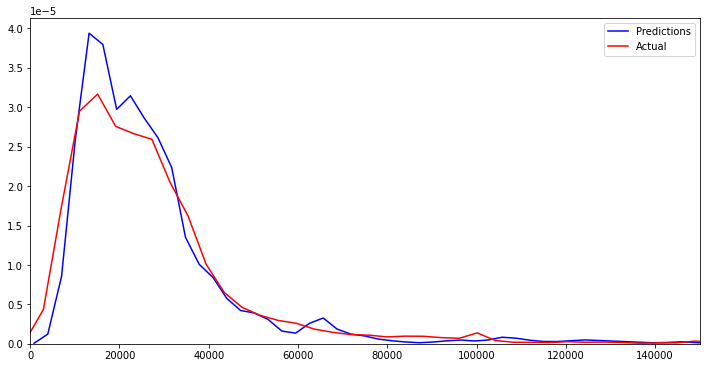

In [53]:
plt.figure(figsize=(12,6))
plt.xlim(0, 150000)
sns.distplot((test_pred), label = 'Predictions', hist = False, color = 'b')
sns.distplot((y_test.to_list()), label='Actual', hist = False, color = 'r')
plt.legend()
plt.show()

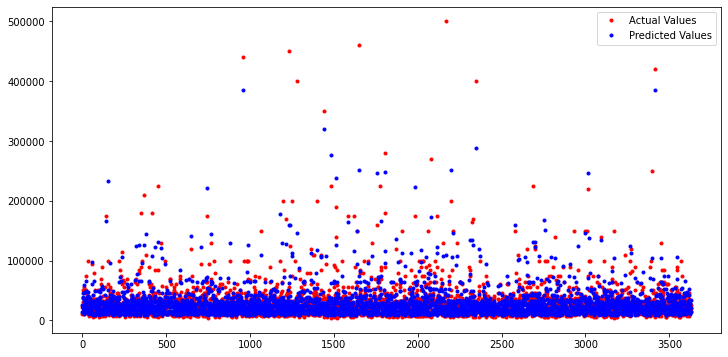

In [56]:
plt.figure(figsize=(12,6))
plt.plot((y_test.to_list()), 'r.', label = 'Actual Values')
plt.plot((test_pred), 'b.', label = 'Predicted Values')
plt.legend()
plt.show()

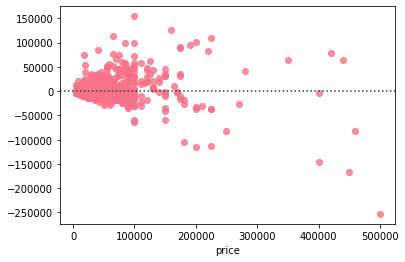

In [57]:
sns.residplot(y_test, test_pred)
plt.show()

#### Feature Importance

In [58]:
cols = data.drop(drop_cols, axis = 1).columns
imp = model.feature_importances_
feat_imp = pd.DataFrame(data = imp, index=cols)

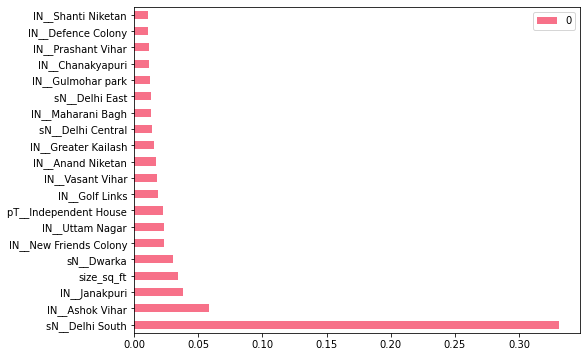

In [59]:
feat_imp.sort_values(by = 0, ascending=False).head(20).plot(kind = 'barh', figsize = (8,6))

## Final Training and Dumping Pipeline
Using joblib to dump the pipeline after training the model on the entire dataset.

In [22]:
pipe_estimators = [('scale', scale), ('model', rf)]
pipe = Pipeline(pipe_estimators)

In [23]:
# Fitting on entire data 
pipe.fit(final_feats, labels)

Pipeline(memory=None,
         steps=[('scale',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('model',
                 RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                       criterion='mse', max_depth=40,
                                       max_features='sqrt', max_leaf_nodes=None,
                                       max_samples=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=5,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=222, n_jobs=-1,
                                       oob_score=True, random_state=None,
                                       verbose=0, warm_start=False))],
         verbose=False)

In [24]:
get_train_metrics(pipe, final_feats, labels)

Training Metrics:
R2 : 0.4425034145348546, stdev 0.26850555792964315
MAE : -8709.497384605636, stdev 2176.5633390477005
MSE : -391888973.2224161, stdev 294202480.8555201


In [63]:
joblib.dump(pipe, 'Models/predict_pipe.pkl')
joblib.dump(rf, 'Models/Model_random_forest.pkl')
joblib.dump(scale, 'Models/Fit_Standard_scalar.pkl')
joblib.dump(final_feats.columns, 'Models/columns.pkl')
joblib.dump(model, 'Models/Model_XGBoost_reg.pkl')

['Models/Model_XGBoost_reg.pkl']

## Making Predictions
Inputs Required
1. size_sq_ft - int
2. NDRLW_dist_km - float (geodisc distance, input listing coordinates from user, slighly less business sense.)
3. Property Type - dropdown list of options. 
4. suburb - object from choices. from dropdown list - possible to get weird combinations different suburb and locality.
5. Locality name - object from choices. from dropdown list - possible to get weird combinations different suburb and locality.(have not constrained this -possible using a dropdown and then filtered options from next dropdown)

#### A. Using Function in this notebook - In memory models or loading pkl
Simply loading the serialised models, fit StandardScaler and predicting using a couple of demo inputs from makaan.com:
1. House in Safdarjung B Block - (2800, Independent Floor, Safdarjung Enclave, Delhi South, 28.560871, 77.190473) - True rent 95K
2. House in Dwarka Sector 4 - (1400, Apartment, Sector 4 Dwarka, Dwarka, 28.602199, 77.053838 ) - True Rent 30K

In [12]:
def predict_rent(pipe, columns):
    """
    Predicts the rent after taking the reuired inputs from the user. Takes in the pickled model,
    preprocessing pipeline - standard scaler and columns.
    """

    # Creating New Dataframe with existing columns
    predict = pd.DataFrame(columns=columns, index=[0])
    predict.fillna(0, inplace=True)

    # inserting simple input.
    size = input("Input the Size of the House in sq. feet")
    predict['size_sq_ft'] = int(size)

    # Inserting one-hot encoded Inputs
    property_type = input("Input the Property Type")
    predict['pT__' + property_type] = 1
    locality_name = input("Input the Locality Name")
    predict['lN__' + locality_name] = 1
    suburb_name = input("Input the Suburb Name")
    predict['sN__' + suburb_name] = 1

     # Calculating Distance from co-ord to NDLS Station
    coordinates = input("Input lat, long").split(',')
    dist_ndls = geodesic(str(coordinates[0]) + ',' + str(coordinates[1]), str(28.6417) + ',' + str(77.2207)).km
    predict['NDRLW_dist_km'] = dist_ndls

    # Final Predictions
    price_pred = pipe.predict(predict)

    print('Predicted Monthly Rent Using Model :', price_pred[0])

#### If In memory :

In [65]:
predict_rent(pipe, final_feats.columns)

Input the Size of the House in sq. feet1400
Input the Property TypeApartment
Input the Locality NameSector 4 Dwarka
Input the Suburb NameDwarka
Input lat, long28.602199, 77.053838
Predicted Monthly Rent Using Model : 28130.612755612754


####  If not in memory:

In [15]:
# Load the saved models and columns, Standard_scaler and import just geodisc for calculating distance from NDLS RLW.
from geopy.distance import geodesic
pipe = joblib.load('Models/predict_pipe.pkl')
rf = joblib.load('Models/Model_random_forest.pkl')
xgb_r = joblib.load('Models/Model_XGBoost_reg.pkl')
scale = joblib.load('Models/Fit_Standard_scalar.pkl')
columns = joblib.load('Models/columns.pkl')

In [16]:
predict_rent(pipe, columns)

Input the Size of the House in sq. feet2800
Input the Property TypeIndependent Floor
Input the Locality NameSafdarjung Enclave
Input the Suburb NameDelhi South
Input lat, long28.560871, 77.190473
Predicted Monthly Rent Using Model : 68319.94136994134


#### B. Using Script/API 
The script that is used for the Flask App can be used to import the predict_rent function and perform the same actions without explicitly needing to load models.

In [17]:
from Models.predict import predict_rent

In [19]:
predict_rent(3000, 'Apartment', 'Delhi South', 'Safdarjung Enclave')

88964.0358666668

In [20]:
predict_rent(1400, 'Apartment', 'Dwarka', 'Sector 4 Dwarka')

29542.388844093635

In [18]:
# Ignore.
#from IPython import display
#for item in rent_data.suburbName.unique():
    #display(rent_data.loc[rent_data['suburbName'] == item].localityName.unique())